# Deep Joint Mean & Quantile Regression
## Key Ideas
Many deep learning models fail to convey uncertainty estimates in their predictions despite the current success in making accurate predictions. One way to overcome this is to predict quantiles in order to construct prediction intervals, which is able to express prediction uncertainty in terms of the coverage percentage and interval length (ICP & MIL which will be discussed later). Besides, with sufficient amount of quantiles, it is possible to approximate the predictive distribution to arbitrarily high precision. However, most approaches attempt to predict each quantile functions individually which often lead to the quantile crossing problem - which contradicts the property of quantile as a non-decreasing function (quantile is essentially the inverse function of CDF which is non-decreasing). 

Therefore, this paper aims to:
1) propose a multi-output multi-quantile deep neural network architecture based on convolutional LSTM layers for jointly predicting the mean and quantiles of the predictive distribution on a 2D grid (our implementation will be 1D)
2) show that approaching the problem of multiple-quantile estimation from a multitask learning perspective solves the quantile crossing problem
3) show that adding the tilted loss (known as pinball loss) to the loss function includes a regularization effect which can lead to better mean predictions

Reference: 
Rodrigues, F., & Pereira, F. C. (2020). Beyond expectation: Deep joint mean and quantile regression for spatiotemporal problems. IEEE transactions on neural networks and learning systems, 31(12), 5377-5389.

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from d2l import torch as d2l

## Hyperparameters
This is the MLP implementation of the same idea, our base input is a 1D time-series data of return values with shape (time) x (number of securities/features). The dataset with around 5200 rows (days) and 14 columns (features) is split into 2400 rows for training, 800 rows for validation and 1600 rows for testing. 

Reference:
https://github.com/fmpr/DeepJMQR/tree/master

In [2]:
#Config Parameters
quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.60, 0.70, 0.80, 0.90, 0.95]
qlen = len(quantiles)
i_train = 2400
i_val = i_train + 800
i_test = i_val + 1600 

Using 1 month data (lag_period = 20 trading days), the model predicts returns and 10 quantiles (11 outputs per day per securities) 2 days ahead (forecast_horizon). For MLP, the 2D shaped inputs fed into the model is flattened into 1D tensor for computation and unflattened afterwards which is how num_inputs & num_outputs are defined.

<br>num_inputs is the tensor length after flattening the input data and num_outputs is the tensor length before unflattening the output data
<br>note: change num_iter to small numbers for quick testing, otherwise it takes a few minutes

In [3]:
batch_size, lr, n_epochs, num_iter = 128, 0.002, 100, 30
lag_period, num_features, forecast_horizon = 20, 14, 2
num_inputs, num_outputs, num_hidden1, num_hidden2 = lag_period*num_features, (1+qlen)*num_features, 200, 200
dropout= 0.2

## Load Data
The date is first removed from the data. Then, the base input (alldata) is organized into inputs (X) and labels (Y). X is of the shape (index) x (time = 20) x (no. of features = 14) which index decides/indicates the starting date. Y contains the returns data 20+2 days ahead of the respective element with same index in X. 
<br> e.g. X[5,:,1] refers to the returns data of day 6 to 25 of the 2nd securities, Y[5,1] refers to the return data on day (5+20+2 = 27) of the 2nd securities

In [4]:
#Load & Split Data
data = pd.read_csv("/Users/lixiang/Desktop/DeepJMQR Project/data.csv")
alldata = np.array(data)[:,1:].astype("float32")
torch.set_default_dtype(torch.float32)
X = []
for i in range(lag_period, len(data)):
    X.append(alldata[i-lag_period:i])
X = torch.tensor(np.array(X), requires_grad = True)
Y = alldata[lag_period+forecast_horizon:]

X and Y are split into training, validation and testing sets and the respective (input,label) pairs are combined into iterations using DataLoader.

In [5]:
X_train, Y_train = X[:i_train], torch.tensor(Y[:i_train])
X_val, Y_val = X[i_train:i_val], Y[i_train:i_val]
X_test, Y_test = X[i_val:i_test], Y[i_val:i_test]
train_iter = torch.utils.data.DataLoader(list(zip(X_train,Y_train)), batch_size=batch_size, shuffle = True)
val_iter = torch.utils.data.DataLoader(list(zip(X_val,Y_val)), batch_size=batch_size, shuffle = False)

## Evaluation & Loss Functions
The functions below are defined such that hopefully, they could be used in both MLP and ConvLSTM implementations.
For the inputs to these functions, they are defined as follows:
1. $\hat{y}$: prediction with shape (index/date) x (no. of features = 14) x (outputs = 1 mean + 10 quantiles) 
2. $y$: observation with shape (index/date) x (no. of features = 14), corresponds to Y_'s in the cell above
3. $\tau$: quantile vector of length (J=10)

$y$ and $\hat{y}$ are tensors for loss function and numpy array for evaluation functions.
All the losses are divided by the number of indices/set size (y.shape[0]) to make them comparable across different dataset sizes.
<br>
<br>

### Loss Function
As defined in the paper, the loss function is the sum of squared errors and tilted loss. The for loop computes the 2nd summation.
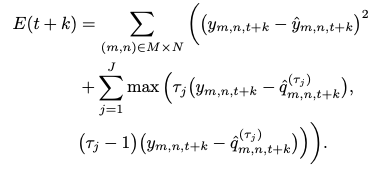

In [6]:
#Evaluation & Loss Functions
def lossfn(τ, y, ŷ):
    loss = torch.sum(torch.square(y-ŷ[:,:,0]))
    for i in range(len(τ)):
        q = τ[i]
        r = y - ŷ[:,:,i+1]
        loss += torch.sum(q*r - r*(r<0))
    loss /= y.shape[0]
    return loss

### Tilted Loss
Similar to the 2nd summation in loss function. Tilted loss is evaluated on quantiles only which is why the final index (i+1) ranges from 1 to 10 for $\hat{y}$.
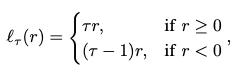

In [7]:
#for evaluation: remember to turn tensors into np.array()
def tilted_loss(τ, y, ŷ):
    loss = 0.0
    for i in range(len(τ)):
        q = τ[i]
        r = y - ŷ[:,:,i+1]
        loss += np.sum(q*r - r*(r<0))
    loss /= y.shape[0]
    return loss

### Crossing Loss & Number of Crosses
Crossing loss and number of crosses are evaluated on neighbouring quantiles only which is why we have final indices of (i+1) and (i+2) (same reason as tilted loss) and for loop range of (11-2=9) for 10 quantiles.

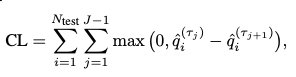

In [8]:
def crossing_loss(ŷ):
    loss = 0.0 #crossing loss as defined in the paper
    num_cross = 0.0
    for i in range(len(ŷ[0,0,:])-2):
        q = ŷ[:,:,i+1] - ŷ[:,:,i+2]
        loss += np.sum(np.maximum(q,0))
        num_cross += np.sum(q>0)
    loss /= ŷ.shape[0]
#     num_cross /= ŷ.shape[0]*ŷ.shape[1]*ŷ.shape[2]
    return loss, num_cross

### Interval Coverage Percentage (ICP) & Mean Interval Length (MIL)
ICP: the fraction of observations (y) that are within the prediction interval
<br>MIL: the average length of the interval
<br> (lower , upper) is the corresponding pair of predicted quantiles e.g. 5% and 95% quantiles, 10% and 90% quanatiles etc

In [9]:
def eval_quantiles(lower, upper, y):
    icp = np.mean((y > lower) & (y < upper))
    mil = np.mean(np.maximum(0,upper-lower))
    return icp,mil

### Errors (MSE, RMSE, MAE)
Standard error functions evaluated on predicted means only. Therefore, the final index for $\hat{y}$ is 0

In [10]:
def eval_error(y, ŷ):
    #y, ŷ: np.array() of same shape as defined in lossfn
    r = np.abs(y-ŷ[:,:,0])
    mse = np.mean(r*r)
    rmse = np.sqrt(mse)
    mae = np.mean(r)
    return mse, rmse, mae

## Training Process
### Model Initialization
initializes weights for the model

In [11]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std = 0.01)

defines the model architecture and returns the model. Since ConvLSTM takes 2D inputs and produces 3D outputs, the inputs need to be flattened before computation and unflattened afterwards for MLP so that we could reuse the evaluation & loss functions.

In [12]:
#Initialize Model
def init():
    net = nn.Sequential(nn.Flatten(), 
                        nn.Linear(num_inputs,num_hidden1),     
                        nn.ReLU(),                    
                        nn.BatchNorm1d(num_hidden1),
                        nn.Dropout(dropout),
                        nn.Linear(num_hidden1,num_hidden2),
                        nn.ReLU(),
#                         nn.BatchNorm1d(num_hidden2),    
#                         nn.Dropout(dropout),
                        nn.Linear(num_hidden2,num_outputs),
                        nn.Unflatten(1,(num_features, (1+qlen))))
    net.apply(init_weights)
    return net

### Train 
inputs data into the model to make predictions, evaluates loss value and makes adjustment to parameters, then returns loss value

Reference: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

"The Training Loop" & "Per-Epoch Activity"

In [13]:
#Train Model
def train(model, train_iter, quantiles, loss_fn, optimizer, num_epochs = 100):
    running_loss = 0
    last_loss = 0
    for i, data in enumerate(train_iter):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(quantiles, labels, outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        last_loss = loss.item()
    return last_loss

### Iteration & Validation
trains the model, validates on validation data, saves the best performing model and returns the prediction using the best model

In [14]:
def iter():
    best_vloss = 1e9
#     animator = d2l.Animator(xlabel = "epoch", ylabel = "loss", xlim = [1,n_epochs], ylim = [0,1], legend = ["train", "val"])
    for epoch in range(n_epochs):
        net.train(True)
        avg_loss = train(net, train_iter, quantiles, lossfn, optimizer, num_epochs = n_epochs)
        net.train(False)
        running_vloss = 0.0
        for i, vdata in enumerate(val_iter):
            vinputs, vlabels = vdata
            voutputs =  net(vinputs)
            vloss = lossfn(quantiles, vlabels, voutputs)
            running_vloss += vloss
        avg_vloss = float(running_vloss / (i+1))
#         if epoch % (n_epochs/20) == 0:
#             animator.add(epoch +1, (avg_loss, avg_vloss))
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(net, "model_best_state")
    model = torch.load("model_best_state")
    pred = model(X_val).detach().numpy()
    return pred

### Reiterate & Evaluate Errors
reiterates a few times due to randomized parameter initialization and stores errors values for computation

In [15]:
#Iterate 
cl,tl,err,icp,mil = [],[],[],[[] for _ in range(qlen//2)],[[] for _ in range(qlen//2)]
for k in range(num_iter):
    net = init()
    optimizer = torch.optim.SGD(net.parameters(), lr = lr)
    pred = iter()
    cl.append(crossing_loss(pred))
    tl.append(tilted_loss(quantiles,Y_val,pred))
    err.append(eval_error(Y_val,pred))
    print("... finished running iter",k+1)
    for i in range(qlen//2):
        t1,t2 = eval_quantiles(pred[:,:,i+1],pred[:,:,qlen-i],Y_val)
        icp[i].append(t1)
        mil[i].append(t2)

... finished running iter 1
... finished running iter 2
... finished running iter 3
... finished running iter 4
... finished running iter 5
... finished running iter 6
... finished running iter 7
... finished running iter 8
... finished running iter 9
... finished running iter 10
... finished running iter 11
... finished running iter 12
... finished running iter 13
... finished running iter 14
... finished running iter 15
... finished running iter 16
... finished running iter 17
... finished running iter 18
... finished running iter 19
... finished running iter 20
... finished running iter 21
... finished running iter 22
... finished running iter 23
... finished running iter 24
... finished running iter 25
... finished running iter 26
... finished running iter 27
... finished running iter 28
... finished running iter 29
... finished running iter 30


### Print Mean of Errors

In [16]:
#Evaluate Errors
def print_error(cl, tl, err, icp, mil):
    print("Crossing Loss:", np.mean([y[0] for y in cl]), ", Number of Crosses:", np.mean([y[1] for y in cl]))
    print("MSE:",np.mean([y[0] for y in err]), "RMSE:", np.mean([y[1] for y in err]),"MAE:", np.mean([y[2] for y in err]))
    print("Tilted loss:", np.mean(tl))
    print("Prediction Intervals:")
    for i in range(qlen//2):
        print(round((quantiles[qlen-i-1]-quantiles[i])*100),"% ICP & MIL:",round(np.mean(icp[i]),6),round(np.mean(mil[i]),6))
#Test data will be touched after everything is done i.e. tuning hyperparameters & adjusting model architecture

In [17]:
print_error(cl, tl, err, icp, mil)

Crossing Loss: 0.011329531307021778 , Number of Crosses: 13583.733333333334
MSE: 4.651343e-05 RMSE: 0.006819934 MAE: 0.00410185
Tilted loss: 0.18695144627491628
Prediction Intervals:
90 % ICP & MIL: 0.944179 0.022756
80 % ICP & MIL: 0.844054 0.015072
60 % ICP & MIL: 0.627289 0.008444
40 % ICP & MIL: 0.419351 0.004837
20 % ICP & MIL: 0.223256 0.002198


### Dummy Prediction
creates a dummy prediction of 0's for comparison

In [18]:
#Dummy Prediction for Comparison
cl,tl,err,icp,mil = [],[],[],[[] for _ in range(qlen//2)],[[] for _ in range(qlen//2)]
p = np.array([[[0 for _ in range(pred.shape[2])] for _ in range(pred.shape[1])] for _ in range(pred.shape[0])])
cl.append(crossing_loss(p))
tl.append(tilted_loss(quantiles,Y_val,p))
err.append(eval_error(Y_val,p))
for i in range(qlen//2):
    t1,t2 = eval_quantiles(p[:,:,i+1],p[:,:,qlen-i],Y_val)
    icp[i].append(t1)
    mil[i].append(t2)

In [19]:
print_error(cl, tl, err, icp, mil)

Crossing Loss: 0.0 , Number of Crosses: 0.0
MSE: 4.343471827510494e-05 RMSE: 0.00659050212617407 MAE: 0.0036727230039435275
Tilted loss: 0.25709061027604696
Prediction Intervals:
90 % ICP & MIL: 0.0 0.0
80 % ICP & MIL: 0.0 0.0
60 % ICP & MIL: 0.0 0.0
40 % ICP & MIL: 0.0 0.0
20 % ICP & MIL: 0.0 0.0


### Some Observations
1. ReLU seems to outperform other activation functions
2. For MLP, the tilted loss is lower than dummy predictions but other error values (MSE, RMSE, MAE) are higher. If the model is actually making somewhat passable predictions the error values should be lower?
3. When we use a high value for dropout e.g. 0.7, it seems like the model stops making predictions but produces similar outputs everyday

some experiments below

In [20]:
np.sum(pred[:,:,0]*Y_val>0)

5362

the cell above shows how many signs are predicted correctly by the model, but it seems like it's always getting around 1/2 only according to the cell below

In [21]:
Y_val.shape[0]*Y_val.shape[1]

11200

In [24]:
print(np.sum(pred[:,1,0]>0))

327


In [25]:
print(np.sum(Y_val[:,1]>0))

419


we get similar result when we look at a particular securities, the model isn't even close to getting the right amount of positive returns
conclusion: it feels like the model is making random/anyhow predictions, there might be some critical mistakes